# Importing Fashion-MNIST dataset
#### Run the next cell before proceding

In [29]:
from torchvision import datasets , transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 600, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

torch.Size([600, 1, 28, 28])


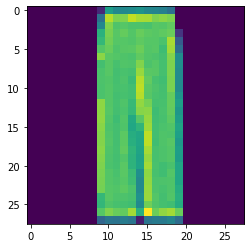

In [30]:
dataiter = iter(trainloader)

image,label = dataiter.next()
print(image.shape)

plt.imshow(image[0].numpy().squeeze())

# Constructing the neural net


In [31]:
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        
        self.convlayers = nn.Sequential(
            nn.Conv2d(1,16,3,stride =1,padding=1),
            nn.ReLU(inplace=True), # 28x28
            nn.MaxPool2d(2,stride=2),#14x14
            nn.Conv2d(16,32,3, stride = 1,padding =1),
            nn.ReLU(inplace=True),#14x14
            
            nn.MaxPool2d(2,stride=2),#7x7
            nn.Conv2d(32,64,3,stride = 1,padding=1),
            
            nn.ReLU(inplace=True)#7x7
            
        )
        self.fc_layer = nn.Sequential(
                        nn.Linear(64*7*7,512),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p=0.5),
                        nn.ReLU(inplace=True),
                        nn.Linear(512,256),
                        nn.BatchNorm1d(256),
                        nn.Dropout(p=0.5),
                        nn.ReLU(inplace=True),
                        nn.Linear(256,128),
                        nn.BatchNorm1d(128),
                        nn.Dropout(p=0.5),
                        nn.ReLU(inplace=True),
                        nn.Linear(128,10),
                        nn.BatchNorm1d(10),
                     
                        nn.ReLU(inplace=True),
                        nn.Softmax(dim= -1))
    def forward(self,x):
        output = self.convlayers(x)
        output = output.view(output.size(0),-1)
        output = self.fc_layer(output)
        
        return output

In [39]:
cnn = net()
cnn = cnn.cuda()

criterion = nn.CrossEntropyLoss()


## Choosing the Optimizer

In [51]:
optimizer = optim.SGD(cnn.parameters(), lr = 0.3,momentum=0.9)

### train function

In [52]:
loss_per_epoch = []
def train(epoch):
    cnn.train()
    
    for i in range(epoch):
        running_loss = 0
        avg_loss = 0
        for j , batch in enumerate(trainloader):
            
            
            image,label = batch
            
            image = image.cuda()
            label = label.cuda()
            
            
            output = cnn(image)
            
            loss = criterion(output,label)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.detach()
            
            avg_loss = running_loss/100
        
        print('average loss '+str(avg_loss.item())+' on '+str(i)+' epoch') 
        loss_per_epoch.append(avg_loss.item())



## test function

In [53]:
def test():
    correct,total = 0,0
    with torch.no_grad():
        for data in testloader:
            images,labels = data
           
            images = images.cuda()
            
            labels = labels.cuda()
            outputs = cnn(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
    accuracy = (correct/total)*100
    print('correct on test set '+ str(correct))
    print('accuracy on test set '+ str(accuracy))

In [54]:
train(200)


average loss 1.469809651374817 on 0 epoch
average loss 1.469552755355835 on 1 epoch
average loss 1.4693772792816162 on 2 epoch
average loss 1.469066858291626 on 3 epoch
average loss 1.469730019569397 on 4 epoch
average loss 1.4694695472717285 on 5 epoch
average loss 1.4689571857452393 on 6 epoch
average loss 1.469127893447876 on 7 epoch
average loss 1.4691047668457031 on 8 epoch
average loss 1.4690439701080322 on 9 epoch
average loss 1.4692655801773071 on 10 epoch
average loss 1.4689702987670898 on 11 epoch
average loss 1.4687401056289673 on 12 epoch
average loss 1.4687976837158203 on 13 epoch
average loss 1.4686869382858276 on 14 epoch
average loss 1.468646764755249 on 15 epoch
average loss 1.4685570001602173 on 16 epoch
average loss 1.468749761581421 on 17 epoch
average loss 1.4687837362289429 on 18 epoch
average loss 1.4688282012939453 on 19 epoch
average loss 1.4688563346862793 on 20 epoch
average loss 1.4685795307159424 on 21 epoch
average loss 1.4687730073928833 on 22 epoch
avera

average loss 1.4673386812210083 on 186 epoch
average loss 1.467435598373413 on 187 epoch
average loss 1.4675308465957642 on 188 epoch
average loss 1.4673649072647095 on 189 epoch
average loss 1.4674406051635742 on 190 epoch
average loss 1.46743643283844 on 191 epoch
average loss 1.4674330949783325 on 192 epoch
average loss 1.4674580097198486 on 193 epoch
average loss 1.4674732685089111 on 194 epoch
average loss 1.4673625230789185 on 195 epoch
average loss 1.4673843383789062 on 196 epoch
average loss 1.4674928188323975 on 197 epoch
average loss 1.4673877954483032 on 198 epoch
average loss 1.467368483543396 on 199 epoch


Text(0, 0.5, 'average loss')

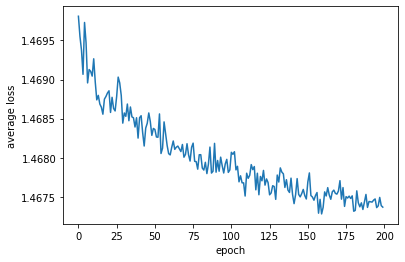

In [55]:
plt.plot(loss_per_epoch)
plt.xlabel('epoch')
plt.ylabel('average loss')


In [56]:
test()

correct on test set 9095
accuracy on test set 90.95


In [111]:
path = './trained_fashion_mnist.pth'
torch.save(cnn.state_dict(),path)

# AutoEncoder 

In [7]:
class autonet(nn.Module):
    def __init__(self):
        super(autonet,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
           
            
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
           
            
            
        )
        
    def forward(self,x):
        output = self.encoder(x)
        output = self.decoder(output)
        
        return output

# Used MSE loss and SGD as optimizer

In [8]:
auto_encoder = autonet()
auto_encoder = auto_encoder.cuda()

criterion_encoder = nn.MSELoss()
optimizer_encoder = optim.SGD(auto_encoder.parameters(),lr = 0.9)
trainloader_encoder = torch.utils.data.DataLoader(trainset, batch_size = 600, shuffle = True)
testloader_encoder = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

## training the autoencoder

In [44]:
losslist=[]
result = torch.Tensor([])
ground_truth = torch.Tensor([])
def train_auto_encoder(epoch):
    auto_encoder.train()
   
    for i in range(epoch):
        running_loss = 0
        avg_loss = 0
        for j , batch in enumerate(trainloader_encoder):
            image,_ = batch
            
            image = Variable(image).cuda()
            
            
            output = auto_encoder(image)
            loss = criterion_encoder(output,image)
            
            optimizer_encoder.zero_grad()
            loss.backward()
            optimizer_encoder.step()
            running_loss += loss.detach()
            avg_loss = running_loss/100
            if i == epoch-1:
                result = output
                ground_truth = image
                f = plt.figure()
                f.add_subplot(1,2, 1)
                plt.imshow(ground_truth.data[0].cpu().numpy().squeeze())
                plt.xlabel('ground truth')
                f.add_subplot(1,2, 2)
                plt.imshow(result.data[0].cpu().numpy().squeeze())
                plt.xlabel('result')
                plt.show(block=True)
        
        print('average loss '+str(avg_loss.item())+' on '+str(i)+' epoch') 
        losslist.append(avg_loss.item())
    print(result.shape)
    print(ground_truth.shape)

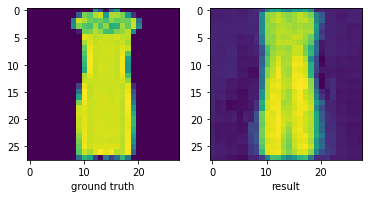

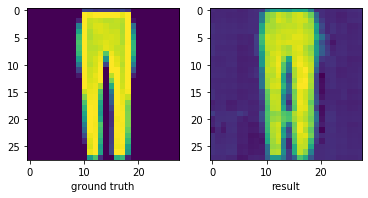

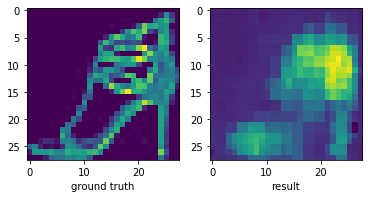

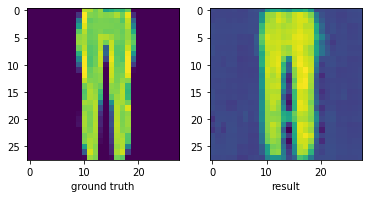

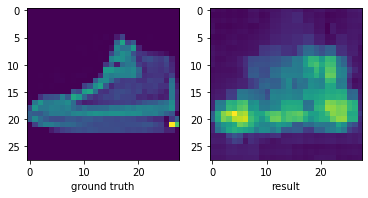

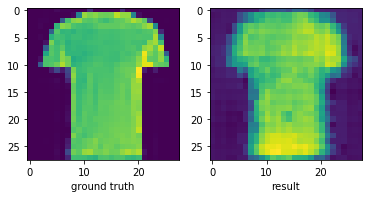

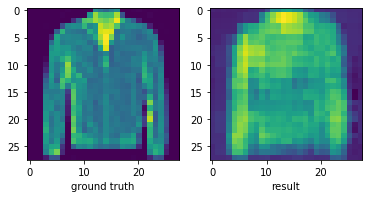

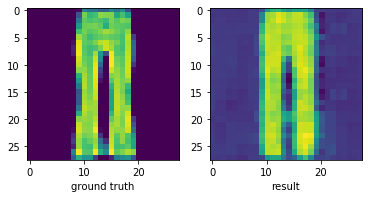

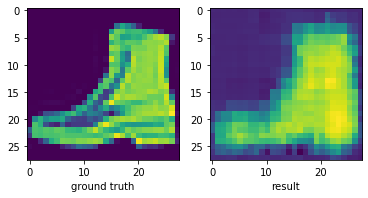

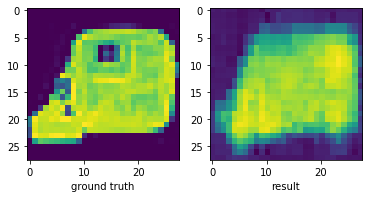

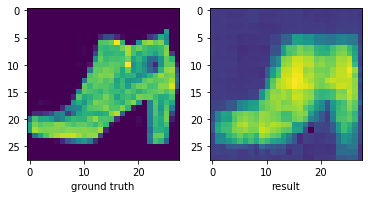

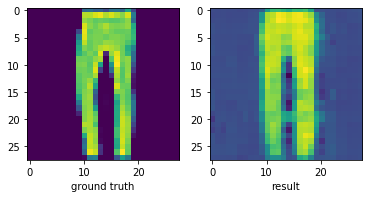

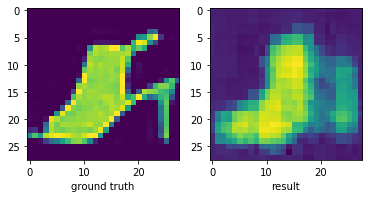

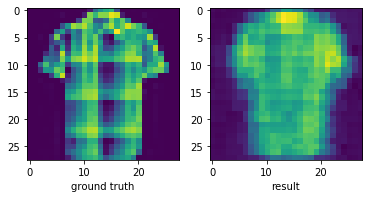

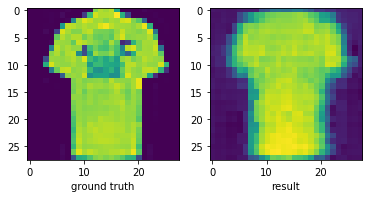

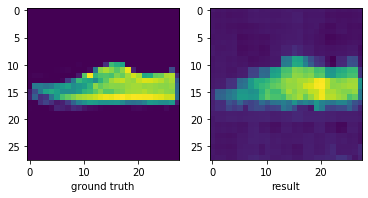

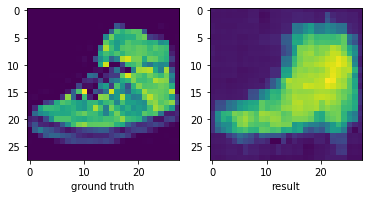

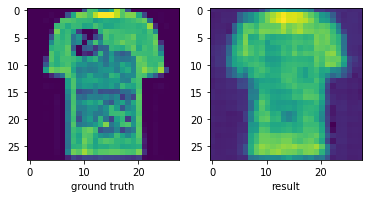

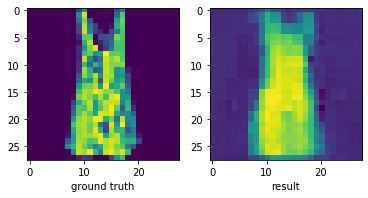

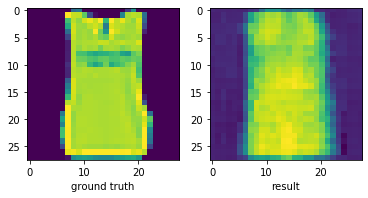

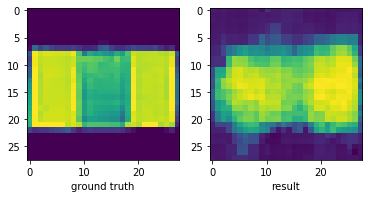

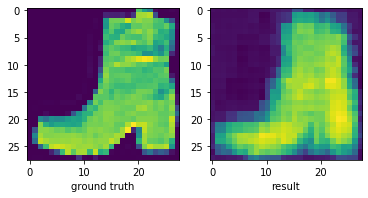

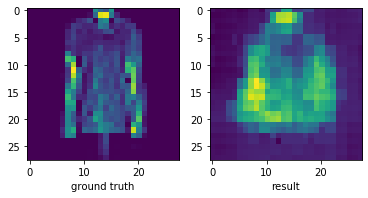

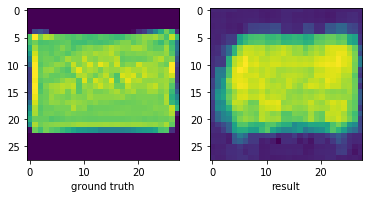

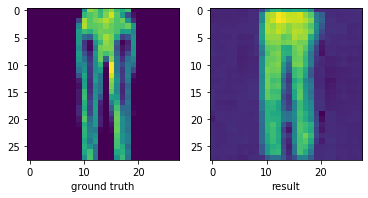

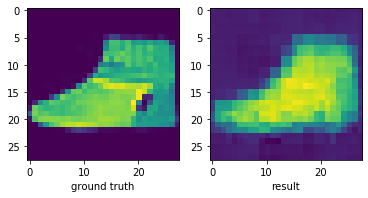

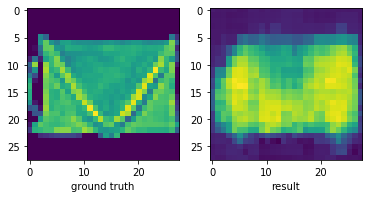

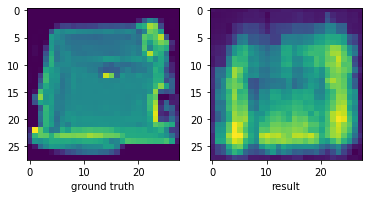

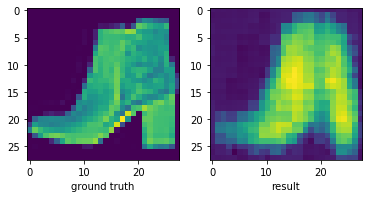

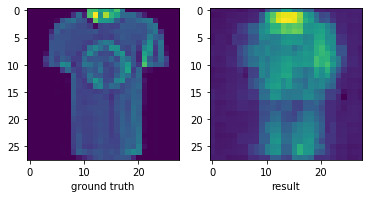

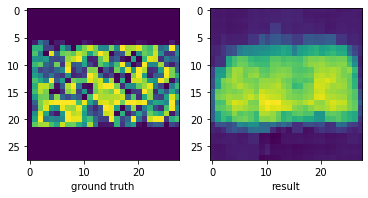

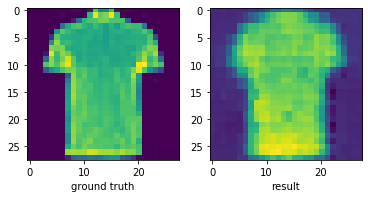

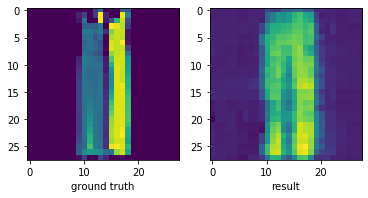

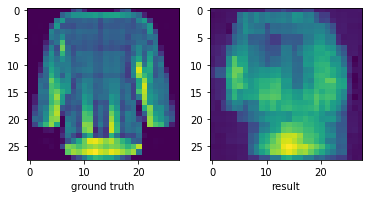

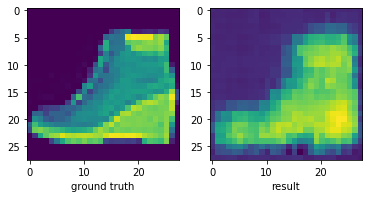

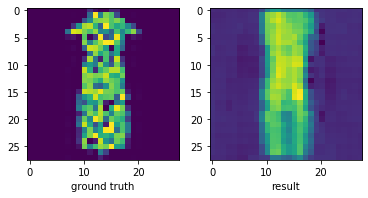

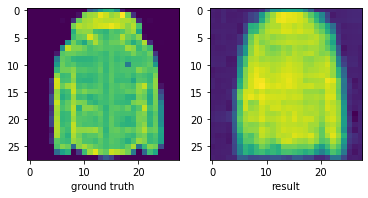

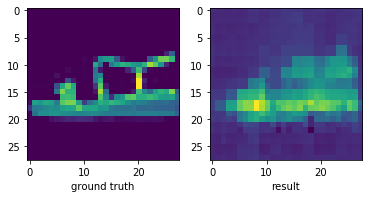

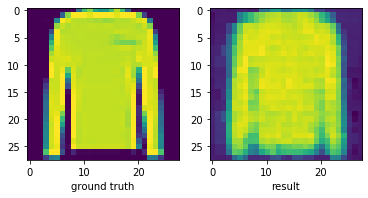

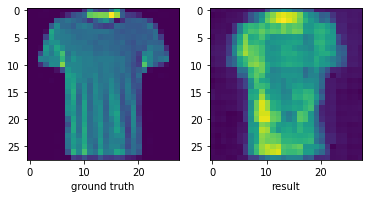

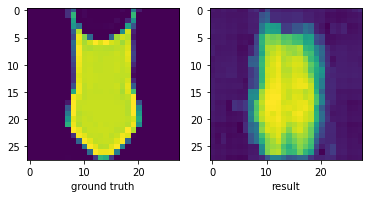

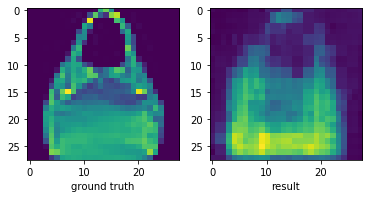

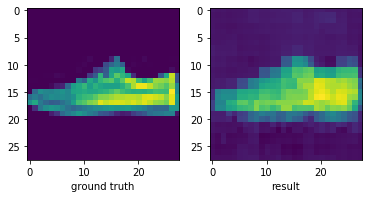

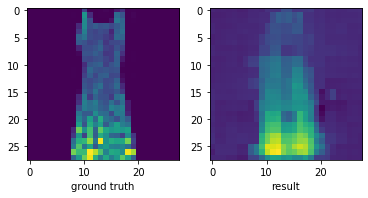

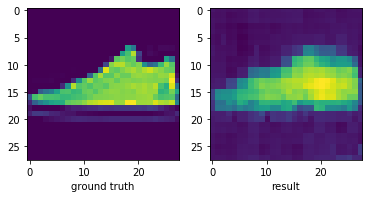

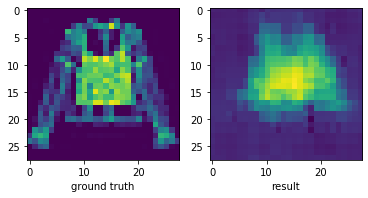

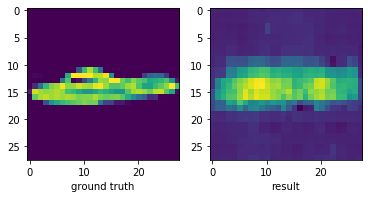

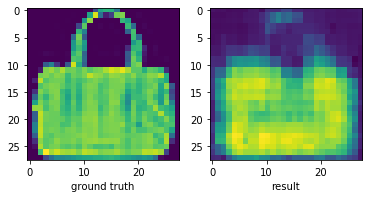

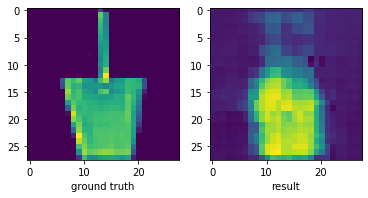

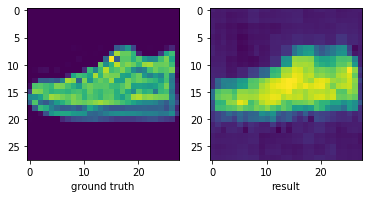

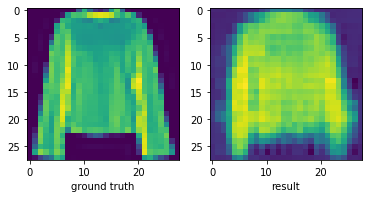

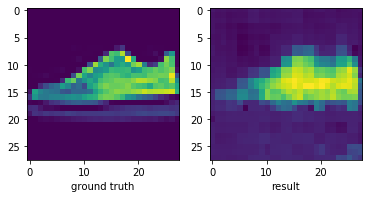

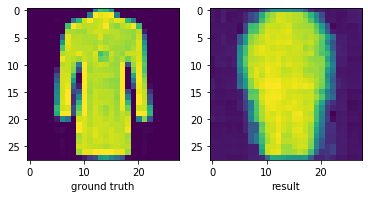

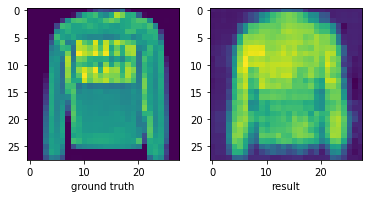

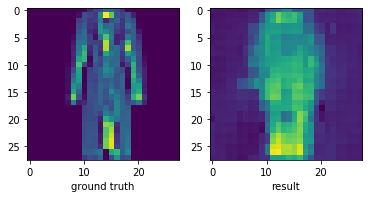

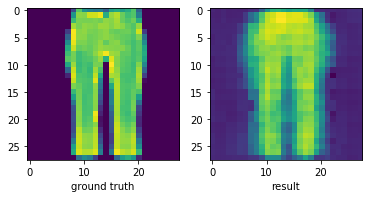

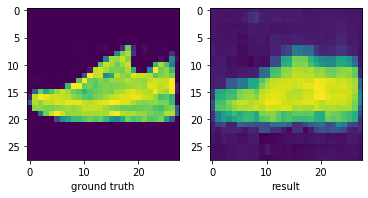

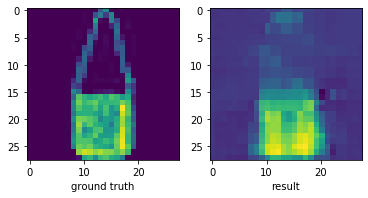

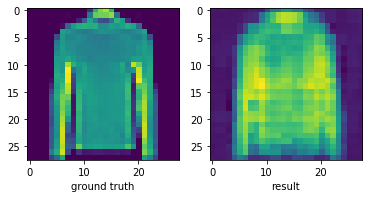

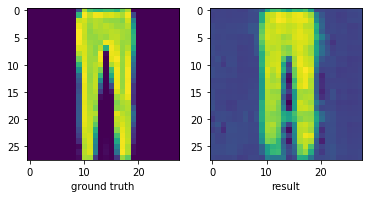

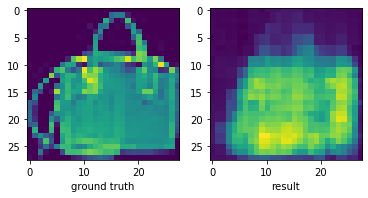

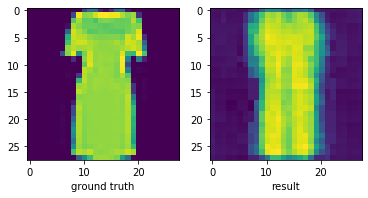

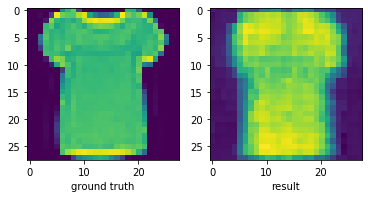

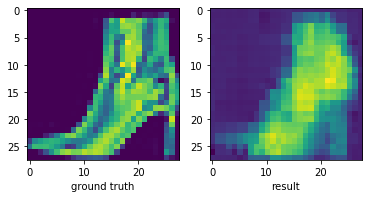

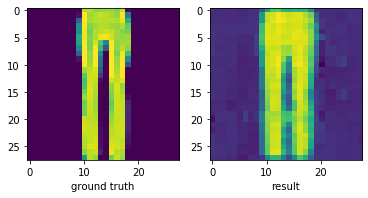

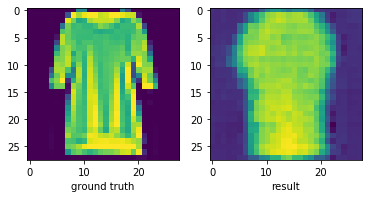

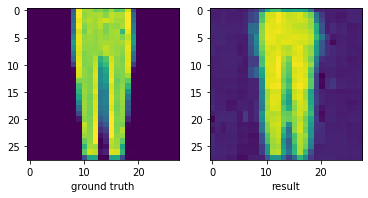

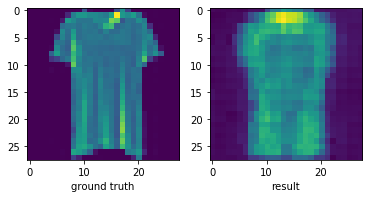

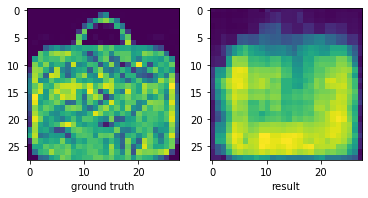

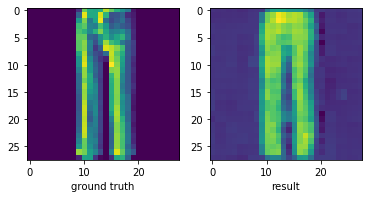

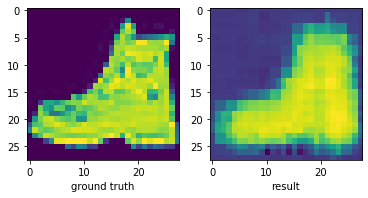

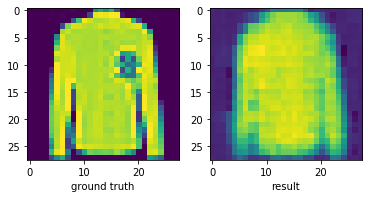

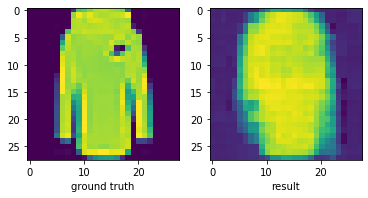

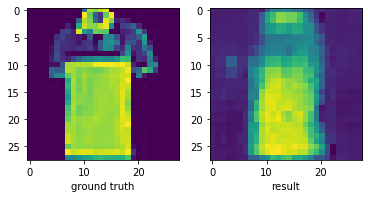

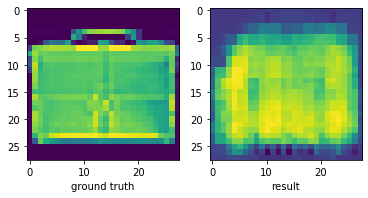

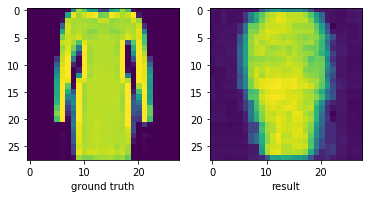

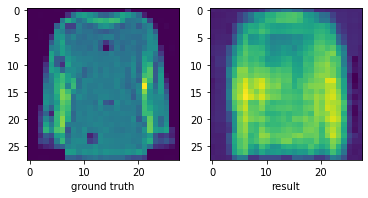

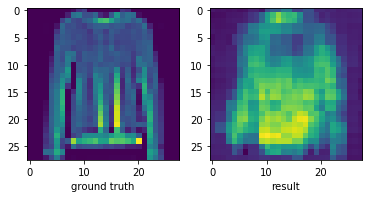

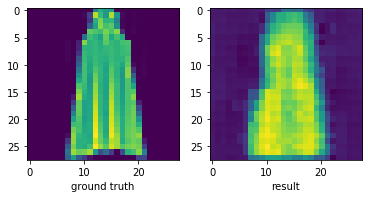

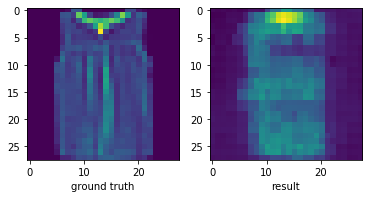

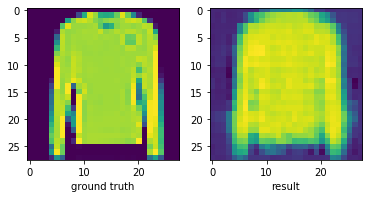

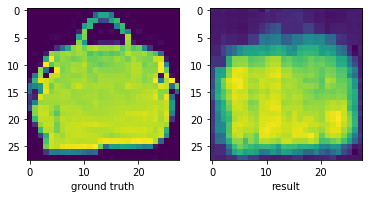

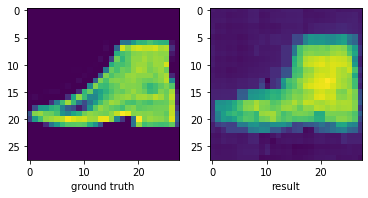

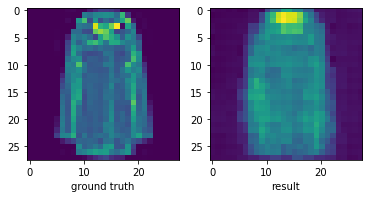

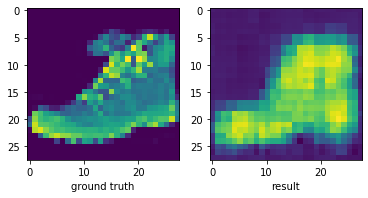

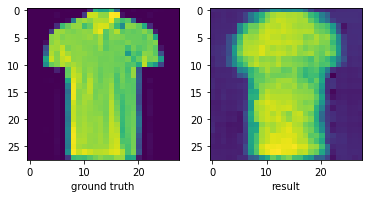

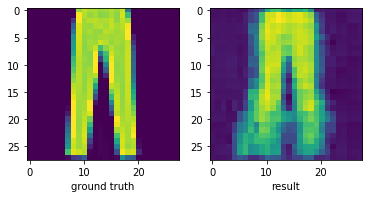

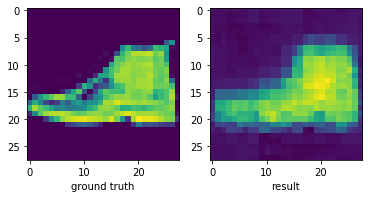

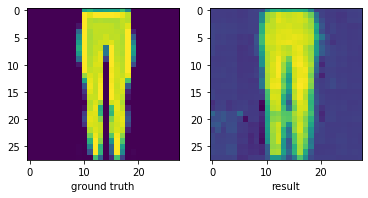

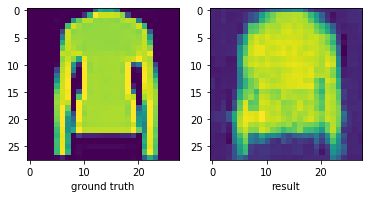

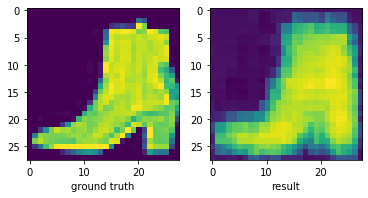

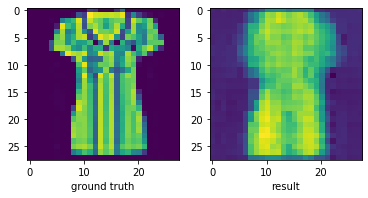

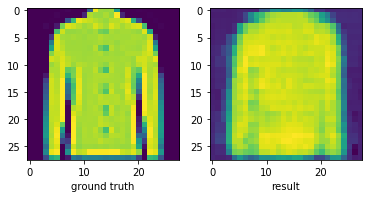

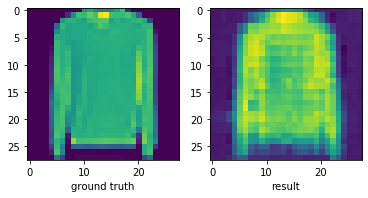

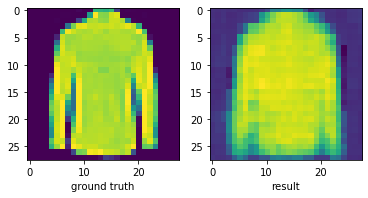

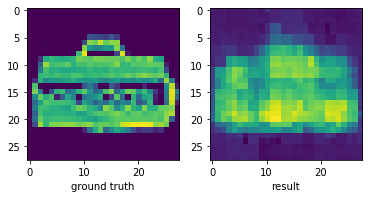

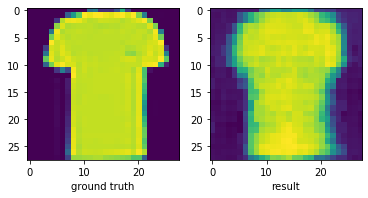

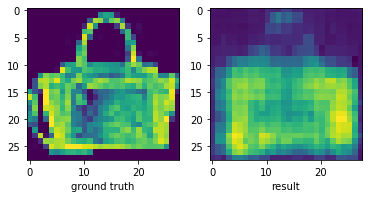

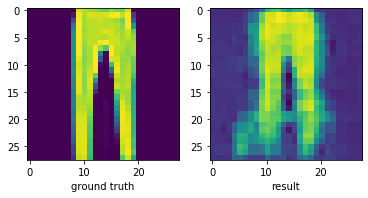

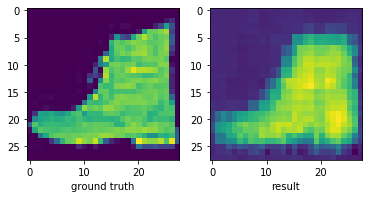

average loss 0.02529335208237171 on 0 epoch
torch.Size([600, 1, 28, 28])
torch.Size([600, 1, 28, 28])


In [47]:
train_auto_encoder(1)